# IMPORTACION DE LIBRERIAS Y LECTURA DEL DATASET

In [94]:
# Librerías básicas
import pandas as pd
import numpy as np
from tabulate import tabulate

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
#Lectura del dataset
df = pd.read_csv("airline_passenger_satisfaction.csv")

In [96]:
# Configura Pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

df.head(10)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,3,2,2,2,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,4,5,5,5,5,5,5,5,4,5,4,4,0.0,satisfied
8,8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,2,2,4,3,3,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,9,65725,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,3,4,2,3,3,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


- Se mira información del dataset: columnas 25, filas 103903, y solo la columna Arrival Delay in Minutes tiene nulos.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

- Se rectifica que solo haya una columna con datos nulos efectivamente solo hay en la columna Arrival Delay in Minutes **310 datos nulos**, posteriormente se decidirá que hacer con estos nulos.

In [98]:
df.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [99]:
df.nunique()

Unnamed: 0                           103904
id                                   103904
Gender                                    2
Customer Type                             2
Age                                      75
Type of Travel                            2
Class                                     3
Flight Distance                        3802
Inflight wifi service                     6
Departure/Arrival time convenient         6
Ease of Online booking                    6
Gate location                             6
Food and drink                            6
Online boarding                           6
Seat comfort                              6
Inflight entertainment                    6
On-board service                          6
Leg room service                          6
Baggage handling                          5
Checkin service                           6
Inflight service                          6
Cleanliness                               6
Departure Delay in Minutes      

- Revisamos los valores unicos de la columna "Arrival Delay in Minutes" para ver si se podia pasar de float a int.

In [100]:
# Utiliza el método unique() para obtener todos los valores únicos
unique_values = df['Arrival Delay in Minutes'].unique()

# Muestra todos los valores únicos en la columna 'Arrival Delay in Minutes'
for value in unique_values:
    print(value)

18.0
6.0
0.0
9.0
23.0
8.0
35.0
51.0
10.0
5.0
4.0
29.0
44.0
28.0
12.0
120.0
24.0
1.0
20.0
31.0
15.0
48.0
26.0
49.0
2.0
37.0
50.0
3.0
19.0
72.0
11.0
34.0
62.0
27.0
52.0
13.0
82.0
30.0
16.0
7.0
122.0
179.0
125.0
17.0
nan
89.0
101.0
14.0
61.0
32.0
33.0
41.0
191.0
138.0
53.0
22.0
57.0
65.0
76.0
107.0
92.0
164.0
21.0
40.0
55.0
185.0
63.0
77.0
86.0
91.0
100.0
54.0
36.0
70.0
139.0
67.0
163.0
128.0
180.0
93.0
121.0
45.0
105.0
126.0
56.0
73.0
212.0
88.0
241.0
172.0
175.0
111.0
99.0
25.0
42.0
226.0
46.0
131.0
260.0
69.0
142.0
58.0
75.0
38.0
66.0
39.0
103.0
307.0
156.0
74.0
109.0
155.0
60.0
154.0
43.0
147.0
217.0
124.0
47.0
150.0
116.0
171.0
84.0
123.0
165.0
94.0
83.0
336.0
59.0
219.0
87.0
459.0
68.0
104.0
133.0
134.0
81.0
259.0
80.0
79.0
222.0
203.0
354.0
214.0
78.0
95.0
71.0
110.0
85.0
146.0
196.0
98.0
470.0
264.0
149.0
113.0
119.0
106.0
216.0
160.0
285.0
115.0
186.0
211.0
323.0
176.0
167.0
242.0
284.0
200.0
145.0
108.0
174.0
132.0
313.0
331.0
288.0
118.0
225.0
64.0
324.0
190.0
177.0
136.0
320.0

In [101]:
columna_a_borrar = ['Unnamed: 0', "id"]
df = df.drop(columna_a_borrar, axis=1)

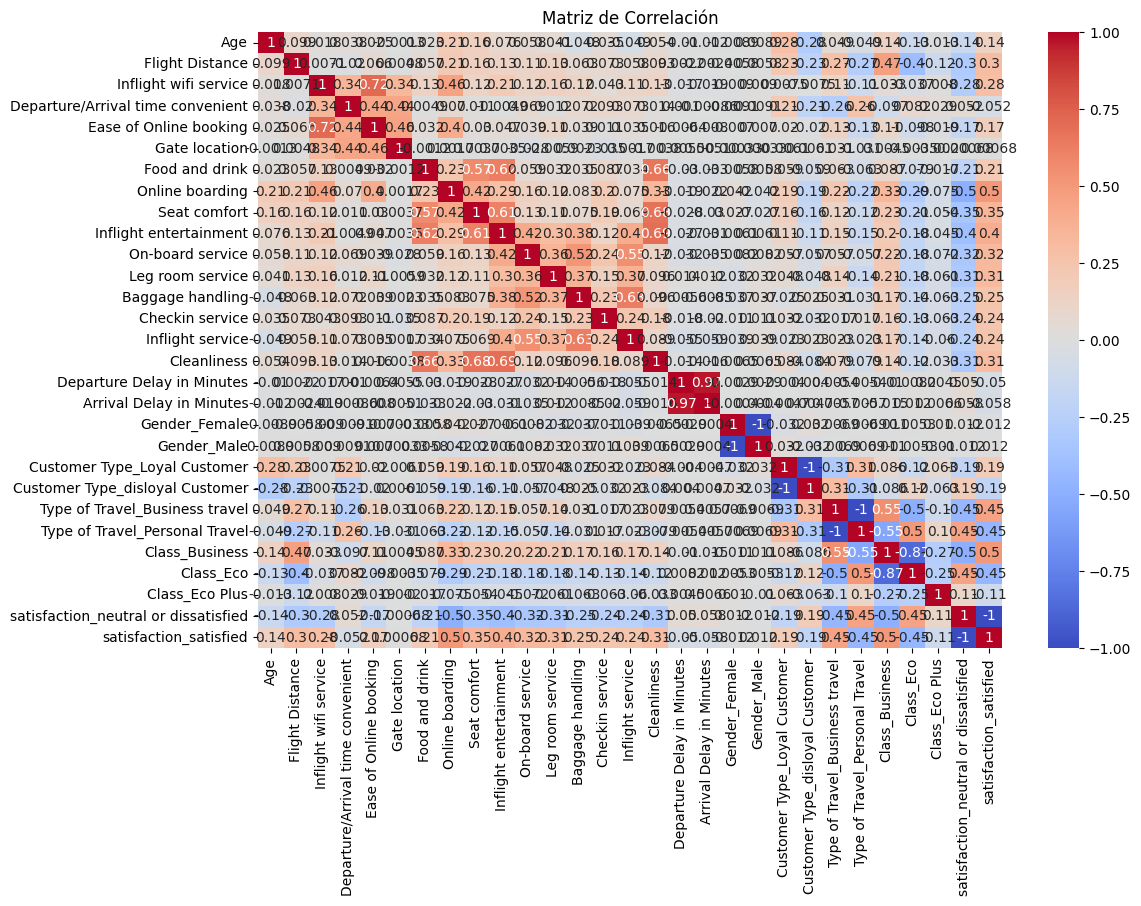

In [102]:
# Codifica las variables categóricas usando one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'])

# Calcula la matriz de correlación para todas las columnas (numéricas y codificadas)
correlation_matrix = df_encoded.corr()

# Visualiza la matriz de correlación como un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

# ANALISIS DE VARIABLES NUMERICAS

In [103]:
var_numericas = ["id","Age","Flight Distance","Inflight wifi service","Departure/Arrival time convenient",	"Ease of Online booking",
                 "Gate location",	"Food and drink",	"Online boarding",	"Seat comfort",	"Inflight entertainment",	"On-board service",	
                 "Leg room service",	"Baggage handling",	"Checkin service",	"Inflight service",	"Cleanliness",	"Departure Delay in Minutes",	
                 "Arrival Delay in Minutes"]


In [104]:
df.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103594.0
mean,39.4,1189.4,2.7,3.1,2.8,3.0,3.2,3.3,3.4,3.4,3.4,3.4,3.6,3.3,3.6,3.3,14.8,15.2
std,15.1,997.1,1.3,1.5,1.4,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.2,1.3,1.2,1.3,38.2,38.7
min,7.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,27.0,414.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,0.0,0.0
50%,40.0,843.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,0.0,0.0
75%,51.0,1743.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,12.0,13.0
max,85.0,4983.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1592.0,1584.0


In [105]:
df[["Seat comfort"]].value_counts()

Seat comfort
4               31765
5               26470
3               18696
2               14897
1               12075
0                   1
Name: count, dtype: int64

In [106]:
df[["Inflight wifi service"]].value_counts()

Inflight wifi service
3                        25868
2                        25830
4                        19794
1                        17840
5                        11469
0                         3103
Name: count, dtype: int64

# ANALISIS DE VARIABLES CATEGORICAS

In [107]:
var_categoricas =[column for column, count in dict(df.nunique()).items()
             if (df[column].dtype=="O") & (count<10)]
var_categoricas

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

In [111]:
# Selecciona las columnas numéricas
columnas_numericas = df.select_dtypes(include=['number'])

# Codifica las variables categóricas usando one-hot encoding
df_encoded = pd.get_dummies(df[var_categoricas], columns=var_categoricas)

# Combina las columnas numéricas con las codificadas
df_combinado = pd.concat([columnas_numericas, df_encoded], axis=1)

# Calcula la matriz de correlación para todas las columnas
correlation_matrix = df_combinado.corr()

# Obtener las correlaciones con respecto a "satisfaction" u otra columna de tu interés
correlations_with_satisfaction = correlation_matrix["satisfaction"].drop("satisfaction")


KeyError: 'satisfaction'

In [ ]:
# Obtener categorías únicas (incluyendo valores nulos) de las columnas deseadas
categorias_por_columna = {}
for columna in var_categoricas:
    categorias = df[columna].unique()
    categorias = [str(cat) if not pd.isnull(cat) else 'NaN' for cat in categorias]
    categorias_por_columna[columna] = categorias

# Mostrar las categorías en una tabla usando tabulate
tabla = []
for columna, categorias in categorias_por_columna.items():
    tabla.append([columna, ", ".join(categorias)])

tabla_formateada = tabulate(tabla, headers=["Columna", "Datos Categorícos (con Nulos)"], tablefmt="grid")
print(tabla_formateada)